In [1]:
import pandas as pd
import numpy as np
import os

base_dir = "../"
data_dir = os.path.join(base_dir, "data")
tracking_dir = os.path.join(base_dir, "MABe-mouse-behavior-detection/train_tracking")
align_summary = os.path.join(data_dir, "frame_alignment_summary.csv")

print("Environment ready")

Environment ready


In [91]:
df = pd.read_csv(align_summary)
print(len(df))
df.head()

847


,tracking_range,annotation_range,tracking_frames,annotation_frames,overlap_frames,tracking_utilization_ratio,annotation_coverage_ratio,status,action,final_range,folder,file
0,"(0, 89975)","(2, 89467)",89976,89466,89466,0.994332,1.0,aligned,none,"(2, 89467)",AdaptableSnail,1212811043.parquet
1,"(0, 53917)","(199, 46370)",53918,46172,46172,0.856337,1.0,manual_review,check_alignment,"(199, 46370)",AdaptableSnail,1260392287.parquet
2,"(0, 81779)","(6, 80461)",81780,80456,80456,0.983810,1.0,auto_trim,trim_to_intersection,"(6, 80461)",AdaptableSnail,1351098077.parquet
3,"(0, 18431)","(49, 18352)",18432,18304,18304,0.993056,1.0,aligned,none,"(49, 18352)",AdaptableSnail,1408652858.parquet
4,"(0, 89975)","(324, 88906)",89976,88583,88583,0.984518,1.0,auto_trim,trim_to_intersection,"(324, 88906)",AdaptableSnail,143861384.parquet


In [92]:
import fastparquet
def trim_tracking_file(track_path, start_frame, stop_frame):
 
    if not os.path.exists(track_path):
        return None, None

    ext = os.path.splitext(track_path)[1].lower()
    if ext == ".csv":
        df_track = pd.read_csv(track_path)
    elif ext == ".parquet":
        df_track = pd.read_parquet(track_path)
    else:
        return None, None

    frame_col = "video_frame" if "video_frame" in df_track.columns else "frame"

    before = df_track[frame_col].nunique()
    trimmed = df_track[(df_track[frame_col] >= start_frame) & (df_track[frame_col] <= stop_frame)]
    after = trimmed[frame_col].nunique()

    keep_ratio = round(after / before, 3) if before > 0 else 0
    return after, keep_ratio



In [93]:
def parse_range(val):
    if pd.isna(val):
        return (None, None)
    if isinstance(val, str):
        try:
            start, stop = ast.literal_eval(val)
            return int(start), int(stop)
        except Exception:
            return (None, None)

    if isinstance(val, (list, tuple)) and len(val) == 2:
        return int(val[0]), int(val[1])
    return (None, None)

df[["final_start", "final_stop"]] = df["final_range"].apply(parse_range).apply(pd.Series)


In [94]:
records = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    folder = row["folder"]
    file = row["file"]

    fstart, fstop = row["final_start"], row["final_stop"]

    if pd.isna(fstart) or pd.isna(fstop):
        continue

    track_path = os.path.join(tracking_dir, folder, file)
    after, ratio = trim_tracking_file(track_path, fstart, fstop)

    records.append({
        "folder": folder, 
        "file": file, 
        "final_start": fstart, 
        "final_stop": fstop, 
        "frames_after": after, 
        "trim_ratio": ratio
    })

df_trimmed = pd.DataFrame(records)
df_trimmed.to_csv(os.path.join(data_dir, "trimmed_summary.csv"), index=False)
print("Trim Summary Saved, ", len(df_trimmed), "files")
df_trimmed.head()

100%|██████████| 847/847 [00:15<00:00, 55.11it/s] 

Trim Summary Saved,  847 files


,folder,file,final_start,final_stop,frames_after,trim_ratio
0,AdaptableSnail,1212811043.parquet,2,89467,89456,0.994
1,AdaptableSnail,1260392287.parquet,199,46370,46172,0.856
2,AdaptableSnail,1351098077.parquet,6,80461,80456,0.984
3,AdaptableSnail,1408652858.parquet,49,18352,18304,0.993
4,AdaptableSnail,143861384.parquet,324,88906,88272,0.984


In [95]:
df = pd.read_csv(os.path.join(data_dir, "trimmed_summary.csv"))
print("Rows: ", len(df))
df.head()

Rows:  847


,folder,file,final_start,final_stop,frames_after,trim_ratio
0,AdaptableSnail,1212811043.parquet,2,89467,89456,0.994
1,AdaptableSnail,1260392287.parquet,199,46370,46172,0.856
2,AdaptableSnail,1351098077.parquet,6,80461,80456,0.984
3,AdaptableSnail,1408652858.parquet,49,18352,18304,0.993
4,AdaptableSnail,143861384.parquet,324,88906,88272,0.984


In [97]:
df["trim_ratio"].describe()

count    847.000000
mean       0.916921
std        0.165197
min        0.001000
25%        0.934000
50%        0.976000
75%        0.992000
max        1.000000
Name: trim_ratio, dtype: float64

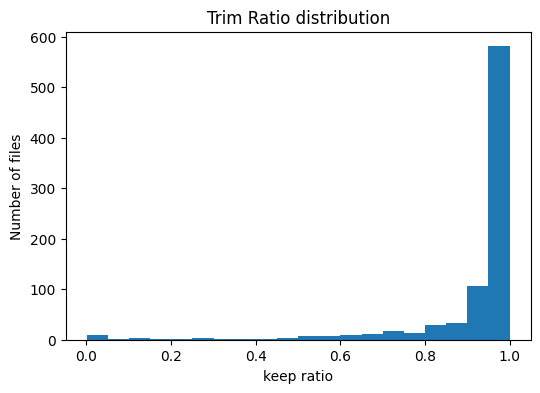

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df["trim_ratio"].dropna(), bins = 20)
plt.title("Trim Ratio distribution")
plt.xlabel("keep ratio")
plt.ylabel("Number of files")
plt.show()

In [99]:
low_ratio = df[df["trim_ratio"] < 0.6]
print(f"Files with low keep ratio (< 0.6): {len(low_ratio)} / {len(df)}")

low_ratio.to_csv("../data/low_ratio_files.csv", index=False)

df_clean = df[df["trim_ratio"] >= 0.6]
print(f"Remaining files after filter: {len(df_clean)}")
df_clean.to_csv("../data/trimmed_summary_filtered.csv", index=False)


Files with low keep ratio (< 0.6): 44 / 847
Remaining files after filter: 803
